In [14]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold

import optuna
from optuna.samplers import TPESampler

## Read data

In [15]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

## Preprocess data

In [16]:
encoder = LabelEncoder()
scaler = MinMaxScaler()

train['Sex'] = encoder.fit_transform(train['Sex'])
test['Sex'] = encoder.transform(test['Sex'])

cat_cols = ['Sex']
target = 'Rings'
continuous_cols = [col for col in train.columns if col not in cat_cols + [target]]

train[continuous_cols] = scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = scaler.transform(test[continuous_cols])

X = train.drop(columns=['Rings'], axis=1).values
y = train['Rings'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.27, random_state=24)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset instances for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 22
# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Define network

In [17]:
class FTTransformerModel(nn.Module):
    """
    FT-Transformer model for regression.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
        """
        Initialize the FT-Transformer model.
        
        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Hidden dimension of the transformer.
            num_layers (int): Number of transformer encoder layers.
            num_heads (int): Number of attention heads.
            dropout (float): Dropout probability.
        """
        super(FTTransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim*4, dropout=dropout, batch_first=True),
            num_layers
        )
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        Perform forward pass through the FT-Transformer model.
        
        Args:
            x (torch.Tensor): Input tensor.
            
        Returns:
            torch.Tensor: Model output.
        """
        x = self.embedding(x)
        x = self.transformer_encoder(x.unsqueeze(1)).squeeze(1)
        x = self.fc(x)
        return x


## Define early stopper

In [22]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
# Define hyperparameters
input_dim = X_train_tensor.shape[1]  # Number of features
params = {'hidden_dim': 64, 'num_heads': 2, 'num_layers': 3, 
 'dropout': 0.19913916019689815, 
    }

# Initialize the model
model = FTTransformerModel(input_dim, **params).to(device)

## Define training loop

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 3.7228, Val Loss: 3.5985


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 3.7179, Val Loss: 3.6139


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 3.7125, Val Loss: 3.5283


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 3.7038, Val Loss: 3.5997


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 3.7084, Val Loss: 3.5444


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 3.7064, Val Loss: 3.5507


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 3.5918, Val Loss: 3.4928


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 3.5773, Val Loss: 3.4913


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 3.5772, Val Loss: 3.4927


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 3.5752, Val Loss: 3.4980


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 3.5735, Val Loss: 3.4945


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 3.5665, Val Loss: 3.4885


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 3.5536, Val Loss: 3.4849


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 3.5568, Val Loss: 3.4841


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 3.5526, Val Loss: 3.4840


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 3.5500, Val Loss: 3.4836


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 3.5490, Val Loss: 3.4836


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 3.5547, Val Loss: 3.4835


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 3.5497, Val Loss: 3.4829


  0%|          | 0/3007 [00:00<?, ?it/s]

  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 3.5491, Val Loss: 3.4832


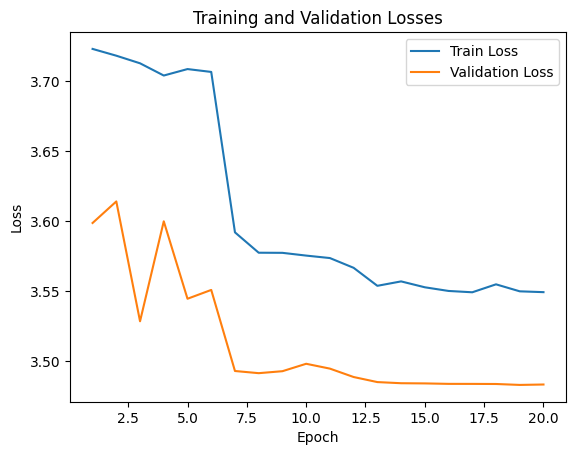

In [25]:
EPOCHS = 20
initial_lr = 0.0005  # Start with a small learning rate
lr_step_size = 6   # Update the learning rate every 6 epochs
lr_gamma = 0.1      # Multiply the learning rate by 0.1 every lr_step_size epochs
criterion = nn.MSELoss()
early_stopping = EarlyStopping(tolerance=3, min_delta=0.1)

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

train_losses = []
val_losses = []

for epoch in trange(EPOCHS):
    # Training phase
    avg_train_loss = []
    model.train()  # Set model to training mode
    for i, (image, mask) in enumerate(tqdm(train_loader)):
        image, mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(image)
        mask = mask.view(-1, 1) 
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        avg_train_loss.append(loss.item())

    avg_train_loss = np.mean(avg_train_loss)

    # Validation phase
    avg_val_loss = []
    model.eval()  # Set model to evaluation mode
    for j, (image, mask) in enumerate(tqdm(val_loader)):
        image, mask = image.to(device), mask.to(device)
        with torch.no_grad():
            output = model(image)
            mask = mask.view(-1, 1)
            loss = criterion(output, mask)
            avg_val_loss.append(loss.item())

    avg_val_loss = np.mean(avg_val_loss)

    # early stopping
    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", i)
      break
    
    tqdm.write(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Apply learning rate scheduling
    scheduler.step()

    # Append the losses for this epoch
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Create a DataFrame to store the losses
loss_df = pd.DataFrame({'val_loss': val_losses, 'train_loss': train_losses})

# Plot the losses
plt.plot(loss_df.index + 1, loss_df['train_loss'], label='Train Loss')
plt.plot(loss_df.index + 1, loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

## Inference

In [27]:
# Inference

test_tensor = torch.tensor(test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    model.eval()
    predictions = model(test_tensor)
predictions

tensor([[ 9.7133],
        [ 9.6166],
        [10.1554],
        ...,
        [12.7128],
        [13.0745],
        [ 8.5461]], device='cuda:0')

## Hyperparameter tune 

In [ ]:
def train_model(params):
    """
    Train the FT-Transformer model with the given hyperparameters.
    
    Args:
        params (dict): Hyperparameters for the model.
        
    Returns:
        float: Average validation RMSE across folds.
    """
    # Unpack the hyperparameters
    input_dim = X_train_tensor.shape[1]
    hidden_dim = params['hidden_dim']
    num_layers = params['num_layers']
    num_heads = params['num_heads']
    dropout = params['dropout']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    early_stopping_patience = params['early_stopping_patience']
    
    # Set the device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create the FT-Transformer model
    model = FTTransformerModel(input_dim, hidden_dim, num_layers, num_heads, dropout).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create KFold cross-validator
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    best_val_rmse_folds = []
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold [{fold+1}/3]")

        # Create train and validation datasets using the indices
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset = torch.utils.data.TensorDataset(X_train_tensor[val_idx], y_train_tensor[val_idx])

        # Create data loaders for train and validation datasets
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

        # Initialize variables for early stopping
        best_val_rmse = float('inf')  # Initialize best_val_rmse here
        best_model_state = None
        patience_counter = 0

        # Training loop
        for epoch in tqdm(range(num_epochs)):
            model.train()
            
            # Iterate over the training batches
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_predictions = []
            val_targets = []
            
            # Iterate over the validation batches
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    val_predictions.append(outputs.squeeze().cpu().numpy())
                    val_targets.append(batch_y.cpu().numpy())
            
            # Concatenate the validation predictions and targets
            val_predictions = np.concatenate(val_predictions)
            val_targets = np.concatenate(val_targets)
            
            # Calculate validation RMSE
            val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation RMSE: {val_rmse:.4f}")
            
            # Check for early stopping
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Store the best validation RMSE for the current fold
        best_val_rmse_folds.append(best_val_rmse)
        
        # Load the best model state for the current fold
        model.load_state_dict(best_model_state)
    
    # Calculate the average validation RMSE across all folds
    avg_val_rmse = np.mean(best_val_rmse_folds)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f}")
    
    return avg_val_rmse

def objective(trial):
    """
    Objective function for hyperparameter optimization.
    
    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        
    Returns:
        float: Average validation RMSE.
    """
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256, step=16)
    num_heads = trial.suggest_int('num_heads', 2, hidden_dim // 16)
    
    while hidden_dim % num_heads != 0:
        num_heads -= 1
    
    params = {
        'hidden_dim': hidden_dim,
        'num_layers': trial.suggest_int('num_layers', 1, 4),
        'num_heads': num_heads,
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'num_epochs': 200,
        'batch_size': trial.suggest_int('batch_size', 16, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'early_stopping_patience': 10
    }
    
    avg_val_rmse = train_model(params)
    
    return avg_val_rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(multivariate=True))

# # Optimize the hyperparameters
study.optimize(objective, timeout=3600 * 10)

# # Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)


### Hyperparameter search space is too long but the best results obtained were:
{'hidden_dim': 64, 'num_heads': 2, 'num_layers': 3, 'dropout': 0.19913916019689815, 'batch_size': 22, 'learning_rate': 0.0004524212208264878}. Best is trial 3 with value: 1.8758653402328491.